Estoy tratando de recuperar la info cruda del final del experimento que hice para medir la dependencia con el umbral. 

De los registros de consentimiento que tengo anotados figura que los datos los tome entre el 29/3/16 y el 14/4/16

La idea es ir a backups de los db.json y volver a procesar todo rapido con la experiencia que ya tengo acumulada para hacer graficos diferentes a los que tengo guardados que son horribles. 

No tengo muy fresco como era el setup experimental ni la estructura de datos guardados, pero voy a ver que puedo hacer al respecto. Deberia tener al menos registro de 14 usuarios. 

Copio a la carpeta data todos los archivos json que corresponden a esas fechas. Quiero un codigo que busque todos los archivos y recupere la info util

Acabo de encontrar en este archivo que los sujetos completaron una encuesta cuando terminaron y tiene marcas temporales!! :)

https://docs.google.com/spreadsheets/d/1hV9QL78TFX2Ka4ROaAg9mHZ2WgcUDArZM2W8W_15wkg/edit#gid=1050318047



In [1]:
#imnportamos cosas y giladas
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np

In [2]:
# Primero queremos listas todos los archivos
onlyfiles = [f for f in listdir('./data/') if isfile(join('./data/', f))]

# Queremos transformar cada archivo en un dataframe con entradas para ver entradas repetidas

import pandas as pd
import json

#Creamos la lista vacia de envios

sesiones = []
levels = []
convergencias = []

#Buscamos leer todas las entradas
for file in onlyfiles:
    with open('./data/'+file) as data_file:
            db = json.load(data_file)
    for envio in db['Envio']:
        if envio['tipoDeEnvio'] == 'NEWSESION':
            sesiones = sesiones + [envio]
        elif envio['tipoDeEnvio'] == 'NEWLEVEL':
            levels = levels + [envio]
        elif envio['tipoDeEnvio'] == 'CONVERGENCIA':
            convergencias = convergencias + [envio]
        elif envio['tipoDeEnvio']:
            print (envio['tipoDeEnvio'])
        else: 
            print (envio)

# Filtramos por envios unicos
envioshechos = []

sesionesUnique = []
for envio in sesiones:
    if not envio['instance'] in envioshechos:
        sesionesUnique = sesionesUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

levelsUnique = []
for envio in levels:
    if not envio['instance'] in envioshechos:
        levelsUnique = levelsUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]

convergenciasUnique = []
for envio in convergencias:
    if not envio['instance'] in envioshechos:
        convergenciasUnique = convergenciasUnique + [json.loads(envio['contenido'])]
        envioshechos = envioshechos + [envio['instance']]


In [3]:
# Acabo de descubrir que los envio de Pierina nunca se hicieron bien. Copie en la carpeta dataCruda los envios que nunca se hicieron y recupere de la compu
onlyfiles2 = [f for f in listdir('./DataCruda/') if isfile(join('./DataCruda/', f))]
import os

for file in onlyfiles2:
    name, ext = os.path.splitext( os.path.basename(file))
    with open('./DataCruda/'+file) as data_file:
            data = json.load(data_file)
    if not int(name) in envioshechos:
        if ext == '.NEWLEVEL':
            levelsUnique = levelsUnique + [data]
        if ext == '.NEWSESION':
            sesionesUnique = sesionesUnique + [data]
        if ext == '.CONVERGENCIA':
            convergenciasUnique = convergenciasUnique + [data]    

        

Definimos la lista de usuarios que hicieron el experimento. Recupere de la compu donde se hicieron quien es quien a partir de las carpetas donde se guardaron los datos

In [4]:
usuarios = {1459443370368:'Agustin', 1460500029182:'Chalukian', 1460568434768:'Chechu',1459459628908:'Euge',
           1459455977180:'Flor', 1459450579229:'Guido', 1460384100961:'Jule', 1459368818910:'Lungo',
           1460497107413:'Marta', 1459358889070:'Martina', 1460645753225:'Pierina', 1459350343607:'Roli'}

In [5]:
# Queremos aplicar un filtro donde, primero se filtren todoas las entradas que tengan una sesion para usuarios validos
sesionesFiltradas = [item for item in sesionesUnique if item['userId'] in usuarios.keys()]
# Por alguna razon se ve que un usuario hizo dos sesiones. 

# Aplicamos un filtro que selecciones los niveles y las convergencias que hayan sucedido en alguna de las sesiones filtradas
sesionesInstances = [item['sessionInstance'] for item in sesionesFiltradas]

levelsFiltrados = [item for item in levelsUnique if item['session']['sessionInstance'] in sesionesInstances]
convergenciasFiltradas = [item for item in convergenciasUnique if item['expLog']['session']['sessionInstance'] in sesionesInstances]

In [6]:
# Pasamos el formato a dataframe
sesionesPanda = pd.DataFrame(sesionesFiltradas)
levelsPanda = pd.DataFrame(levelsFiltrados)
convergenciaPandas = pd.DataFrame(convergenciasFiltradas)

In [115]:
### Retocamos un poco la info para que sea mas manejable (basicamente hay que extraer cada cosa de adentro de los dict
cpd = convergenciaPandas

# Extraemos la info del exp log
for key in cpd.iloc[0]['expLog']:
    cpd[key] = cpd['expLog'].map(lambda x: x[key])
cpd = cpd.drop('expLog',1)
for key in cpd.iloc[0]['session']:
    cpd[key] = cpd['session'].map(lambda x: x[key])
cpd = cpd.drop('session',1)
cpd = cpd.drop(['codeVersion','plataforma','sessionInstance','resourcesVersion'],1)

# Extraemos la info de la dinamica
for key in cpd.iloc[0]['dinamica']:
    cpd[key] = cpd['dinamica'].map(lambda x: x[key])
cpd = cpd.drop('dinamica',1)
cpd = cpd.drop(['listaEstimulos','proporcionAciertos','sdEsperada','tamanoVentanaAnalisisConvergencia','saltosActivos',
                'ultimoMEAN','ultimaSD'],1)

# Extraemos la info del ultimo trial del historial
cpd['ultimoTrial'] = cpd['historial'].map(lambda x: x[-1] if (len (x) > 1) else None)
for key in cpd.iloc[0]['ultimoTrial']:
    cpd[key] = cpd['ultimoTrial'].map(lambda x: x[key] if (x) else None)
cpd = cpd.drop('ultimoTrial',1)
cpd = cpd.drop(['nivelEstimulo','acertado'],1)

# Extraemos la info del ultimo estimulo
for key in cpd.iloc[0]['estimulo']: # Hay que tener cuidado que no todos los dict son iguales. Este es un dict de paralelismio
    cpd[key] = cpd['estimulo'].map(lambda x: None if not x else x[key] if key in x else None)
for key in cpd.iloc[7]['estimulo']: # Hay que tener cuidado que no todos los dict son iguales. Este es un dict de angulos
    cpd[key] = cpd['estimulo'].map(lambda x: None if not x else x[key] if key in x else None)
cpd = cpd.drop('estimulo',1)
cpd = cpd.drop(['nivelSenal','class','idResource','idTrial'],1)
#Revisando los archivos fuente dentro del jar de la versión 31 (que es la que se uso en el experimento) chequie que el valor reportado de los estimulos es el semi angulo para el caso de las serie de paralelismo.
#En el caso de los angulos, es el angulo formado, que ya procesa el tema dela desviacion.
cpd["umbral"] = cpd.apply(lambda row: row["desviacion"] *2 if pd.isnull(row["anguloFormado"]) else 90 - row["anguloFormado"], axis=1)
cpd['umbral'] = cpd['umbral'].map(lambda x: x if x>=0 else -x)

# Sacamos niveles espureos
cpd = cpd[cpd['expName']!='UmbralAngulosTutorial']
cpd = cpd[cpd['expName']!='UmbralParalelismoTutorial']

# Sacamos los registros de niveles que se marcaron en tiempo de ejecusion como no temrinados
cpd = cpd[cpd['convergenciaFinalizada']]

Respecto al analisis anterior tenemos varias cosas para mejorar. Por un lado quitar los alphas porque no ayuda a que se vea bien. Por otro lado hay que poolear todos los datos por sujeto

Queremos hacer:
1) Un histograma de umbral de detección para cada serie por separando por experimento (12 graficos) donde no mergemos los sujetos  (aclarando que es la info cruda)
2) Un analisis de los datos A90 contra binomial 1/2
3) Analisis de todas las series contra binomial 1/2 para P
4) Analisis de todas las series (excepto las descartadas en 2) contra bonomial 1/3 para A
5) Grafico de barras descartando lo que se va en 3 y 4 con test de significancia.

Vamos a hacer 1)

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


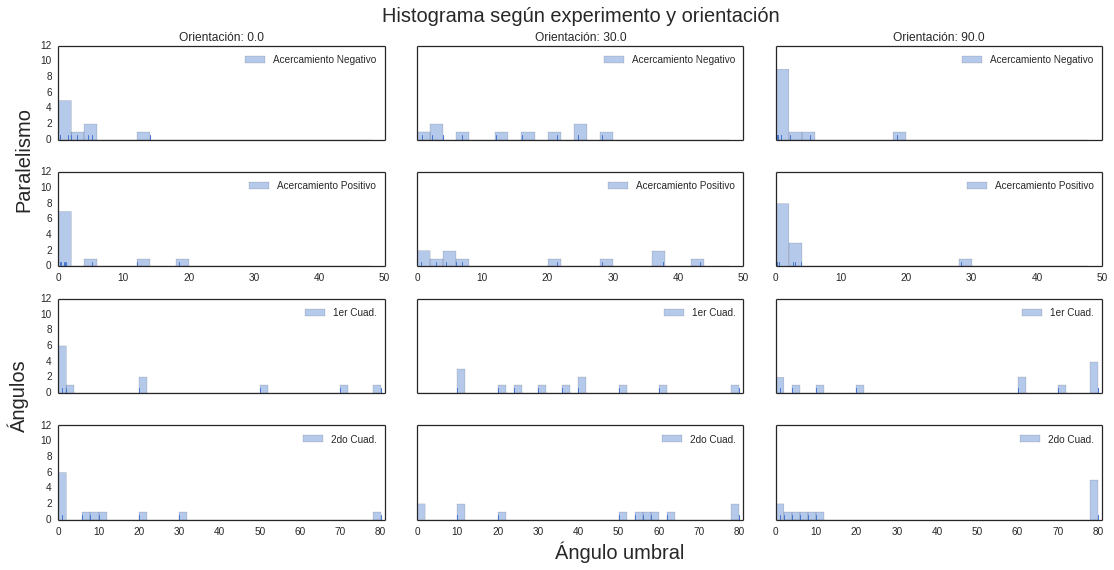

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(4,3)
fig.set_size_inches(15,7)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

limite1=81
limite2=50
paso = 2
for i, experimento in enumerate(cpd['expName'].unique()):
    for j, orientacion in enumerate(cpd['referencia'].unique()):
        
        if experimento == 'UmbralParalelismoPiloto':
            data1 = cpd[((cpd['expName']==experimento) & (cpd['referencia']==orientacion)) & (cpd['identificador']=='Acercamiento Negativo')]
            data2 = cpd[((cpd['expName']==experimento) & (cpd['referencia']==orientacion)) & (cpd['identificador']=='Acercamiento Positivo')]
            sns.distplot(data1['umbral'], label=data1.iloc[0]['identificador'], axlabel='', ax=ax[2*i,j], kde=False, bins=range(0, limite2, paso),rug=True)
            sns.distplot(data2['umbral'], label=data2.iloc[0]['identificador'], axlabel='', ax=ax[2*i+1,j], kde=False, bins=range(0, limite2, paso),rug=True)
            ax[0,j].set_title('Orientación: '+str(orientacion))
        
        if experimento == 'UmbralAngulosPiloto':
            data1 = cpd[((cpd['expName']==experimento) & (cpd['referencia']==orientacion)) & (cpd['identificador']=='1er Cuad.')]
            data2 = cpd[((cpd['expName']==experimento) & (cpd['referencia']==orientacion)) & (cpd['identificador']=='2do Cuad.')]
            sns.distplot(data1['umbral'], label=data1.iloc[0]['identificador'], axlabel='', ax=ax[2*i,j], kde=False, bins=range(0, limite1, paso),rug=True)
            sns.distplot(data2['umbral'], label=data2.iloc[0]['identificador'], axlabel='', ax=ax[2*i+1,j], kde=False, bins=range(0, limite1, paso),rug=True)
            ax[0,j].set_title('Orientación: '+str(orientacion))
        
        
for axi in [axi for axi2 in ax for axi in axi2]:
    axi.set_ylim([0, 12])
    axi.get_xaxis().set_visible(False)
    axi.get_yaxis().set_visible(False)
    axi.legend()

for axi in ax[0]:
    axi.set_xlim([0, limite2])
for axi in ax[1]:
    axi.set_xlim([0, limite2])
for axi in ax[2]:
    axi.set_xlim([0, limite1])
for axi in ax[3]:
    axi.set_xlim([0, limite1])
    
for axi in ax[-1]:
    axi.get_xaxis().set_visible(True)
for axi in ax[-3]:
    axi.get_xaxis().set_visible(True)
for axi in [x[0] for x in ax]:
    axi.get_yaxis().set_visible(True)


ax[0,1].text(25,15,'Histograma según experimento y orientación', fontsize=20, ha='center')
ax[3,1].text(50,-5,'Ángulo umbral', fontsize=20, ha='center')
ax[0,0].text(-5,2,'Paralelismo', fontsize=20, ha='center', rotation=90)
ax[2,0].text(-10,2,'Ángulos', fontsize=20, ha='center', rotation=90)
        
fig.savefig('./../Images/Exp1_DataCruda', bbox_inches='tight')
fig.show()

Vamos a hacer 2)

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


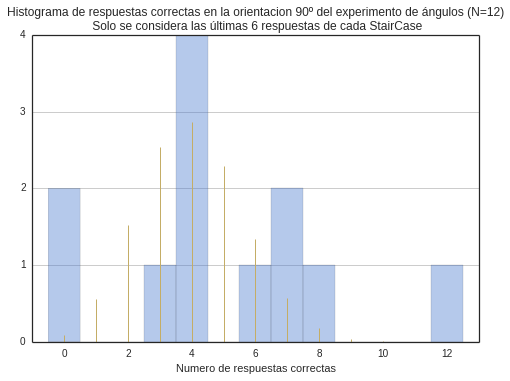

In [268]:
# Primero debemos seleccionar los datos correspondientes a el experimento A90
dataF = cpd[(cpd['expName']=='UmbralAngulosPiloto') & (cpd['referencia']==90)]
# Segundo, extraemos la lista de respuestas del historial
datos = []
for row in dataF.iterrows():
    row = row[1]
    data = {}
    data['Experimento'] = row['expName']
    data['Usuario'] = row['userId']
    data['Convergio'] = row['convergenciaFinalizada']
    data['referencia'] = row['referencia']
    data['aciertos'] = [x['acertado'] for x in row['historial']]
    data['niveles'] = [x['estimulo']['nivelSenal'] for x in row['historial']]
    data['identificador'] = row['identificador']
    datos = datos + [data]

for dato1 in datos:
    for dato2 in datos:
        if dato1['Usuario']==dato2['Usuario']:
            if dato1['identificador']!=dato2['identificador']:
                dato1['ConjuntoRtas'] = [dato1['aciertos'],dato2['aciertos']]

DataLinda = pd.DataFrame(datos)
# Tiramos uno de cada dos mediciones que corresponden al mismo usuario
DataLinda = DataLinda.drop_duplicates(['Usuario'])
# Buscamos el conjunto de las ultimas 6 rtas en cada serie y contamos cuantas bien hubo
DataLinda['Acumulado6'] = DataLinda['ConjuntoRtas'].map(lambda x: sum(x[0][-6:]) + sum(x[1][-6:]))


# Ahora vamos a hacer un histograma de esto.
import scipy.stats as stats

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
proba = [stats.binom.pmf (i,12,1/3) for i in range(13)]
bins = [x+0.5 for x in range(-1, 16, 1)]
ax = sns.distplot(DataLinda['Acumulado6'], axlabel='Numero de respuestas correctas', kde=False, bins=bins)
for i, value in enumerate(proba):
    ax.vlines(i, 0, 12*value, colors=sns.color_palette()[4], lw=1)
    
ax.set_xlim([-1, 13])
ax.set_yticks([0,1,2,3,4])
ax.yaxis.grid(True)
ax.set_title ('Histograma de respuestas correctas en la orientacion 90º del experimento de ángulos (N=12) \n Solo se considera las últimas 6 respuestas de cada StairCase')
fig.savefig('./../Images/Exp1_Saturacion', bbox_inches='tight')
fig.show()

Vamos a hacer 3)

In [280]:
lala = cpd.groupby("levelInstance")["historial"].apply(tuple)
pepe = cpd.drop_duplicates("levelInstance").set_index("levelInstance")
pepe["new var"] = lala
pepe = pepe.reset_index()
pepe.head()

144
72
72


Hay tendencias obvias en los graficos, pero estaria bueno hacer algun tipo de test para verificarlo. 

Vamos a realizar test para ver que nos muestras no vienen de distribuciones con la misma forma (Wilcoxon):

In [9]:
import scipy.stats as stats
import itertools

print ('\n Resultados para comparación de las distribuciones de angulos: \n')

for data , label in zip (itertools.combinations(dataAngulos, 2), itertools.combinations(dataAngulosL, 2)):
    print ('Analisis Wilcoxon para ' + str(label[0]) + 'º y ' + str(label[1]) + 'º: ' + str(stats.ranksums(data[0],data[1])[1]))
    print ('Analisis mannwhitneyu para ' + str(label[0]) + 'º y ' + str(label[1]) + 'º: ' + str(stats.mannwhitneyu(data[0],data[1])[1]))

print ('\n Resultados para comparación de las distribuciones de parelelismo: \n')

for data , label in zip (itertools.combinations(dataParalelismo, 2), itertools.combinations(dataParalelismoL, 2)):
    print ('Analisis Wilcoxon para ' + str(label[0]) + 'º y ' + str(label[1]) + 'º: ' + str(stats.ranksums(data[0],data[1])[1]))
    print ('Analisis mannwhitneyu para ' + str(label[0]) + 'º y ' + str(label[1]) + 'º: ' + str(stats.mannwhitneyu(data[0],data[1])[1]))

       


 Resultados para comparación de las distribuciones de angulos: 

Analisis Wilcoxon para 0.0º y 30.0º: 0.00243673480899
Analisis mannwhitneyu para 0.0º y 30.0º: 0.00115916279673
Analisis Wilcoxon para 0.0º y 90.0º: 0.00856349280462
Analisis mannwhitneyu para 0.0º y 90.0º: 0.00398321093915
Analisis Wilcoxon para 30.0º y 90.0º: 0.877099304782
Analisis mannwhitneyu para 30.0º y 90.0º: 0.442045607901

 Resultados para comparación de las distribuciones de parelelismo: 

Analisis Wilcoxon para 0.0º y 30.0º: 0.0345567656796
Analisis mannwhitneyu para 0.0º y 30.0º: 0.0174626487004
Analisis Wilcoxon para 0.0º y 90.0º: 0.00830736241984
Analisis mannwhitneyu para 0.0º y 90.0º: 0.00376678424634
Analisis Wilcoxon para 30.0º y 90.0º: 2.11075911744e-06
Analisis mannwhitneyu para 30.0º y 90.0º: 9.54564214677e-07


En el cuadro anterior verificamos que hay un caso particular en donde da que no hay diferencia significativa, que es en angulos a 90º. en relacion a 30º Esto era algo que esperabamos. Hay una cuestion que fue diseñada a drede, y es que en esa configuracion, el sujeto puede confundir el lado fijo de que sea hacia arriba o hacia abajo. Como el setup experimental pedia responder por opciones agudo-recto-obtuso, si el sujeto interpreta al reves entonces va a responder sistematicamente mal. 

Los datos de los trials pueden dar respuestas correctas o incorrectas. Por la logica de funcionamiento del staircase, la señal "converge" cuando hay una relacion aproximada de 2 a 1 de respuesta correctas. Esta proporcion puede variar en los primeros trials respondidos porque todavia la señal no se estabilizo. Por lo tanto algo que se puede hacer es observar cual es la probabilidad de que se de la proporcion que se dio de respuestas correctas en los ultimos trials respondidos y comparar contra la distribucion de probabilidad de que esa sea una estadisticamente factible asumiendo la hipotesis de respuesta random. Si da muy baja puede o bien ser que el sujeto responda sistematicamente por encima de la media (porque esta en la zona umbral de deteccion), que responda al azar o que responda sistematicamente mal. Para eso lo primero que hacemos es cargar un codigo que calcula la distribucion en funcion de los trials realizados

In [10]:
def distribucionDeProbabilidadRandom (histograma):
    """
        Esta funcion sirve para analizar cual es la probabilidad de responder N trials correctos en funcion del setup del level y poder tener una medida de la significancia de la cantidad de aciertos medidos.
        Para eso se asume que la hipotesis nula es responder al azar y se calcula a partir de la cantidad de trials que hay con cada cantidad de opciones por trial cual seria la probabilidad de acierto respondiendo al azar.

        El input (histograma), es un vector de enteros donde cada casillero representa la cantidad de trials que hay en el level con ese numero de opciones (en realidad como el primer elemento del vector es el 0, en dicho casillero esta la cantidad de trials con una unica opcion a elegir y asi sucesivamente)
        El output es un vector de floats que representa la probabilidad de responder N (donde N es el indice del valor) respuestas correctas respondiendo al azar.
    """

    import sys
    if not sys.version_info[:2] == (3, 4):
        print ('Sos un boludo!, pero uno previsor')
        print ('Este codigo esta pensado para correr en python 3.4')


    import math

    distribuciones = [0] * len(histograma)
    # Primer calculamos la distribucion de probabilidad para cada subset de trials con identicas opciones de respuesta
    for i in range(len(histograma)):
        N = i+1 # Representa el numero de opciones posibles a elegir
        m = histograma[i] # Representa el numero de trials que se contestan en el subset
        subset_N = [0] * (m+1) # Sumamos el 1 porque si hay cero elementos igual hay una opcion, las opciones son el cerrado [0,numero de trials]
        p = 1/N # es la probabilidad de acertar entre la cantidad de opciones presentadas (que es i+1)
        if m==0:
            distribuciones[i] = [1]
        else:
            for j in range(m+1): # j representa la cantidad de opciones correctas
                # Calculamos la probabilidad de obtener una cantidad de respuestas correctas j, cuando cada trial tiene N opciones
                Pj = math.pow(p,j)*math.pow(1-p,m-j)*math.factorial(m)/(math.factorial(j)*math.factorial(m-j))
                subset_N[j] = Pj
            distribuciones[i] = subset_N
    # Aqui ya esta la distribucion de cada subset. ahora hay que calcular la distribucion global, para eso hay que combinar las dritribciones

    # La idea es que si tenemos dos distribuciones N1 y N2 cada uno con J y J' elementos (donde J y J' es el numero de trials maximo que hay con N1 y N2 opciones)
    # y j1 representa la probabilidad de responder j1 veces bien en los trials de N1 opciones y j2 representar la probabilidad de responder j2 veces bien
    # en los trials de N2 opciones,
    # entonces la suma de todos los productos cuyos indices j1 +j2 de j3 es la probabilidad de responde j3 veces bien entre los trials de N1 y N2 opciones
    combinado = [1] # Inicialmente hay probabilidad 1 de tener 0 bien
    for N in range(len(distribuciones)):
        combinadoNew = [0] * (sum(histograma)+1) # Armo una combinacion que este vacia
        for i_1 in range(len(combinado)):
            if combinado[i_1] != 0: # Esto tiene dos razones, una es evitar cuentas innecesarias. La otra mas importante es evitar que aplique el contador hasta el final y que la suma de los dos contadores de mas que el numero de trials maximos posible, lo que genera un error
                for i_2 in range(len(distribuciones[N])):
                    combinadoNew[i_1+i_2] = combinadoNew[i_1+i_2] + combinado[i_1]*distribuciones[N][i_2] #Acumulo todos las combinaciones
        combinado = combinadoNew

    return combinado


/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


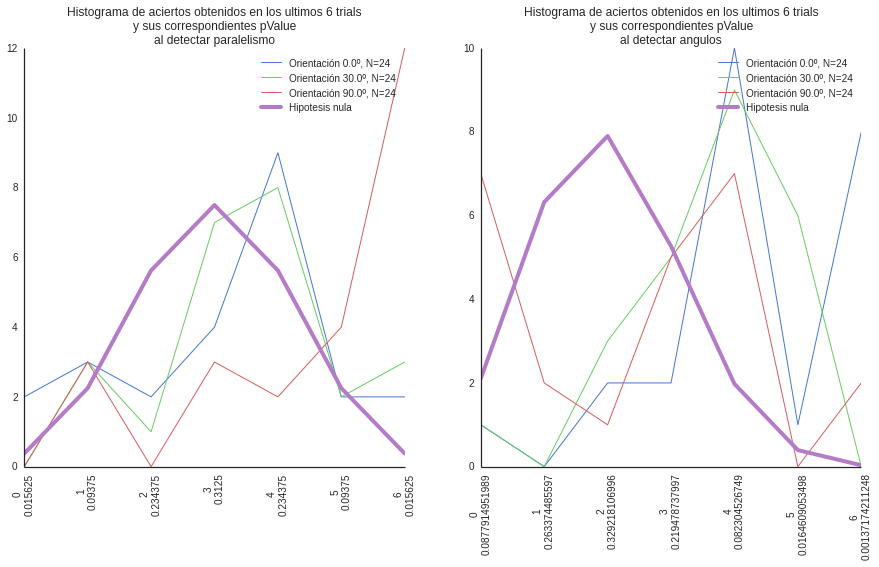

In [59]:
# Lo primero es que vamos a analizar los ultimos diez trials o los que se hayan hecho si fueron menos

N = 6

cpd['ultimosTrials'] = cpd['historial'].map(lambda x: x[-N:])
cpd['trialsRealizados'] = cpd['ultimosTrials'].map(lambda x: len(x))

# Contamos los trials correctos
cpd['trialsCorrectos'] = cpd['ultimosTrials'].map(lambda x: sum([trial['acertado'] for trial in x]))

# Creamos la columna con distribuciones
cpd['distribucion'] = None
# Cargamos los datos de distribuciones para los angulos
cpd['distribucion'].loc[cpd['anguloFormado'].notnull()] = cpd[cpd['anguloFormado'].notnull()]['trialsRealizados'].map(lambda x: distribucionDeProbabilidadRandom([0,0,x]) if x<10 else distribucionDeProbabilidadRandom([0,0,N]))
# Cargamos los datos de distribuciones para paralelismo
cpd['distribucion'].loc[cpd['anguloFormado'].isnull()] = cpd[cpd['anguloFormado'].isnull()]['trialsRealizados'].map(lambda x: distribucionDeProbabilidadRandom([0,x]) if x<10 else distribucionDeProbabilidadRandom([0,N]))
# calculamos el pValue
cpd['pValue'] = cpd[['distribucion', 'trialsCorrectos']].apply(tuple, axis=1).map(lambda x: 1 - sum(x[0][:x[1]]))
                                                                                  




# Ahora vamos a repetir la idea de los grafico anteriores pero en pValue

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.despine(left=True)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7.5)

bins = range(N+1)

for experimento in cpd['expName'].unique():
    for orientacion in cpd['referencia'].unique()[:3]:

        data=cpd[((cpd['referencia']==orientacion) & (cpd['expName']==experimento)) & (cpd['trialsRealizados']==N)]['trialsCorrectos']
        histo = [0]*(N+1)
        for dato in data:
            histo[dato] = histo[dato] + 1

        if experimento == 'UmbralParalelismoPiloto':
            ax[0].plot(histo, label='Orientación ' + str(orientacion)+'º, N=' + str(len(data)), linewidth=1.0)
        if experimento == 'UmbralAngulosPiloto':
            ax[1].plot(histo, label='Orientación ' + str(orientacion)+'º, N=' + str(len(data)), linewidth=1.0)

# Agregamos la hipotesis nula
hipNula=[]
for i in bins:
    hipNula = hipNula + [stats.binom.pmf (i,N,1/2)*24]
ax[0].plot(hipNula, label='Hipotesis nula', linewidth=4.0)

hipNula=[]
for i in bins:
    hipNula = hipNula + [stats.binom.pmf (i,N,1/3)*24]
ax[1].plot(hipNula, label='Hipotesis nula', linewidth=4.0)

# agregamos los labels
paraLabels = [str(i) + '\n' + str(stats.binom.pmf (i,N,1/2)) for i in bins]
paraAngulos = [str(i) + '\n' + str(stats.binom.pmf (i,N,1/3)) for i in bins]


for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(True)
    ax[i].get_yaxis().set_visible(True)
    ax[i].legend()
    ax[i].set_xticks (bins)
    
ax[0].set_xticklabels(paraLabels, rotation=90)
ax[1].set_xticklabels(paraAngulos, rotation=90)
    

text = 'Histograma de aciertos obtenidos en los ultimos ' + str(N) + ' trials\n'
text = text + 'y sus correspondientes pValue \n'
ax[0].set_title(text +'al detectar paralelismo')
ax[1].set_title(text +'al detectar angulos')

#cpd.columns
fig.savefig('./../Images/ExperimentoUmbralPerfomrnace'+str(N), bbox_inches='tight')
fig.show()

In [17]:
cpd['trialsRealizados']

4     15
5     15
6     15
7     15
8     15
9     15
10    12
11    12
12    15
13    15
14    15
15    15
20    15
21    15
22    15
...
195    15
196    15
197    15
202     8
203    15
204    15
205    15
206    14
207    14
208    12
209    15
210    15
212    15
213    15
214     6
Name: trialsRealizados, Length: 144, dtype: int64